In [1]:
USE_WIDGETS = False
if USE_WIDGETS:
    %matplotlib widget
else:
    %matplotlib inline
import matplotlib as mpl

import numpy as np
import scipy
import pylab
import skimage
import os
import matplotlib.pyplot as plt
from scipy import ndimage

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np

In [2]:
def improperties(image):
    print("Image properties:")
    print("   shape:", image.shape)
    print("   type:", type(image))
    print("   element type:", type(image[0, 0]))
    print("   size:", image.size)
    print("   shape:", image.shape)
    print("   min:", image.min())
    print("   max:", image.max())
    print("   mean:", image.mean(), '\n');

## Zadatak 1

Slika je u __HDR__, high dinamic range, formatu. Vrednosti piksela su predstavljene sa 16 bita. Kako monitori imaju ograničeni opseg, potrebno je preskalirati vrednosti piksela ulazne slike na odgovarajući opseg. Preskaliranje možemo izvršiti na opseg $[0, 1]$, gde maksimalnoj vrednosti dodelimo $1$ a minimalnoj $0$. Na taj način ne gubimo informacije. Ukoliko bismo prikazali sliku sa takvim opsegom na standardnom displeju, dobijamo jako tamnu sliku. Razlog je taj što HDR slika sadrži jako veliki opseg vrednsoti piksela, ukoliko u slici imamo svetle i tamne delove, udaljenost vrednosti takvih piksela je velik. Standardni displeji imaju ograničen opseg, koji je manji od HDR opsega, pa se tamni delovi pretvaraju u $0$ a svetli u $1$.

<br>
<center><img src="images_report/img01.jpg" width = 400/>                   <img src="images_report/hist_street_in.png" width = 500/></center>

<br>
<br>
Takav problem možemo izbeći smanjivanjem globalnog kontrasta, tj. izvlačenjem informacija iz tamnih delova slike, u ovom slučaju. Kako je osetljivost ljudskog vizualnog sistema logaritamska, najlogičnije rešenje bi bila __logaritamska transformacija__. Pored logaritamske transformacije, možemo iskoristiti i __stepenu transformaciju__ , čiji je stepen iz opsega $(0, 1)$. 

<br>
<br>
$$
    \large y = a \, \log(1 + k \, x) \,\,\,\,\,\, y = a \, x^k
$$

<br>
<center><img src="images_report/s1.png" width = 400/></center>

<br>
Upravo se ovo vidi na histogramu. Histogram ulazne slike je skoncentrisan oko manjih vrednosti intenziteta piksela. Da bismo izvukli informacije iz tamnih delova slike potrebno je razvuci histogram ka visim vrednostima. Izlazna slika dobijena primenom logaritamske transformacije na ulaznu, i njen histogram su prikazani na slici.
<br>
<center><img src="images_out/street.jpg" width = 400/>                         <img src="images_report/hist_street_out.png" width = 500/></center>

<br>
<br>
Izvlačenje detalja iz tamnih delova slike bi se moglo odraditi i __ekvalizacijom histograma__, ili __adaptivnom ekvalizacijom histograma__. Ekvalizacija histograma gleda celu sliku i pokušava da je transformiše tako da histogram transformisane slike bude konstantan, neće biti u potpunosti jer je slika diskretni sistem. S'obzirom da je rastojanje između visokih i niskih vrednosti piksela jako udaljene, i da ima mnogo manje svetlih piksela, ova transformacija daje previše svetlu sliku. Adaptivna ekvalizacija histograma deli ulaznu sliku na segmente i vrši ekvalizaciju histograma segmenata. Na taj način možemo sačuvati detalje u jako tamnim i u jako svetlim delovima slike. Mana adaptivne ekvalizacije je ta što može dati, vrlo često, neprirodne odnose boja i što je vrlo kompleksna, tj. skupa operacija. Ukoliko se isti, ili sličan, rezultat može postići nekom drugom transformacijom, ne treba koristiti adaptivnu ekvalizaciju, s'obzirom da je ona najkompleksnija. 

<br>
<br>
<center><img src="images_report/street_adapteq.jpg" width = 400/>                         <img src="images_report/street_eq.jpg" width = 400/></center>

In [3]:
# Logaritamska funkcija
def log_transform(img, c):
    
    img_out = np.log(1 + (10**c) * img) / np.log(1 + 10**c)  # Sobzirom da je log funksija sporo rastuća, k = 10**c, gde se uzima c kao parametar
    img_out = skimage.img_as_ubyte(img_out);                 # Transformacija podatka iz float64 u uint8
    
    return img_out;

# Stepena funkcija, gde je k iz opsega (0, 1)
def root_transform(img, k):
    
    img_out =  abs(img)**k
    img_out = skimage.img_as_ubyte(img_out);   # Transformacija podatka iz float64 u uint8
    
    return img_out;

# Funkcija koja nalazi parametre koji daju najbolje rezultate 
# koriscenjem interact-a
def best_result_0(img, c_log, k_root):
    
    img_log_trans = log_transform(img, c_log)
    img_root_trans = root_transform(img, k_root)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,8), dpi=120)
    ax = axes.ravel()
    
    ax[0].imshow(img_log_trans)
    ax[0].axis('off')
    
    ax[1].imshow(img_root_trans)
    ax[1].axis('off')
    plt.show();

# Funkcija koja cuva histograme ulazne slike i izlazne slike
def save_hist(img, y12):
    img = skimage.img_as_ubyte(img)
    hist_img, bin_edges = np.histogram(img.flatten(), bins=256, range=(0,255))
    hist_y12, bin_edges = np.histogram(y12.flatten(), bins=256, range=(0,255))
    
    fig, ax = plt.subplots()
    plt.bar(bin_edges[0:-1], hist_img, color='b')
    plt.title("Histogram ulazne slike")
    plt.savefig("images_report/hist_street_in.png")
    fig, ax = plt.subplots()
    plt.bar(bin_edges[0:-1], hist_y12, color='b')
    plt.title("Histogram izlazne slike")
    plt.savefig("images_report/hist_street_out.png")

# Funkcija koja vrsi ekvalizaciju i adaptivnu ekvalizaciju histograma
def save_equalisation(img):
    
    # Ekvalizacija histograma
    img_eq = skimage.exposure.equalize_hist(img)
    img_eq = skimage.img_as_ubyte(img_eq);

    # Adaptivna ekvalizacija histograma sa ograničenjem kontrasta
    img_adapteq = skimage.exposure.equalize_adapthist(img, clip_limit=0.04)
    img_adapteq = skimage.img_as_ubyte(img_adapteq);
    
    plt.imsave("images_report/street_eq.jpg", img_eq);
    plt.imsave("images_report/street_adapteq.jpg", img_adapteq);

Iterativnim putem, menjanjem parametara, utvrđeno je da je se najbolji rezultat dobija primenom __logaritamske transformacije__ za $k = 10^{2.3}$. Logaritamska transformacija je dala malo bolje rezultate zato što je uzet koa parametar $c = \log(k)$ dok je za parametar stepene funkcije uzeto $k$. Može se i za stepenu fuunkciju uzeti parametar $c = 20 \, k$, smanjili bismo korak, pa bi se dobili približni rezultati. 

/home/uroslinux/venv/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


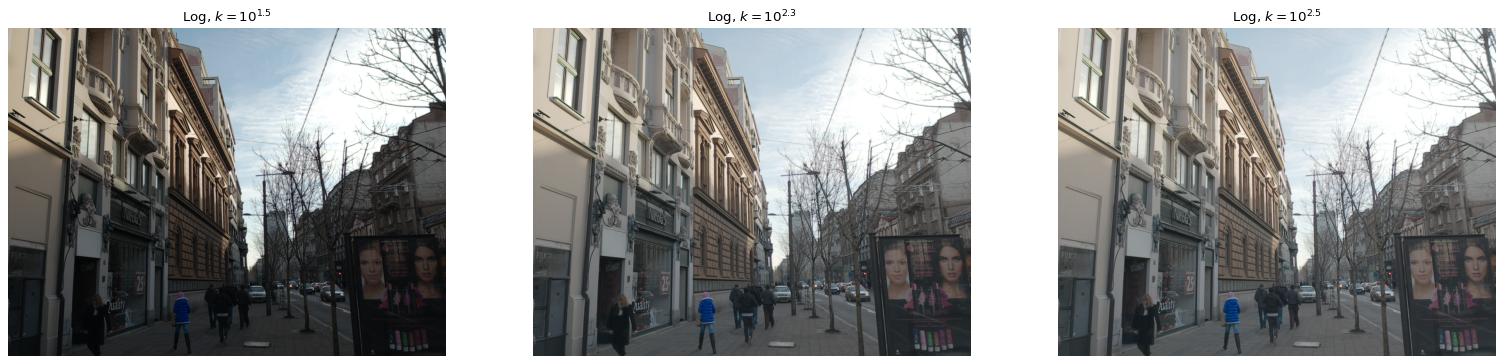

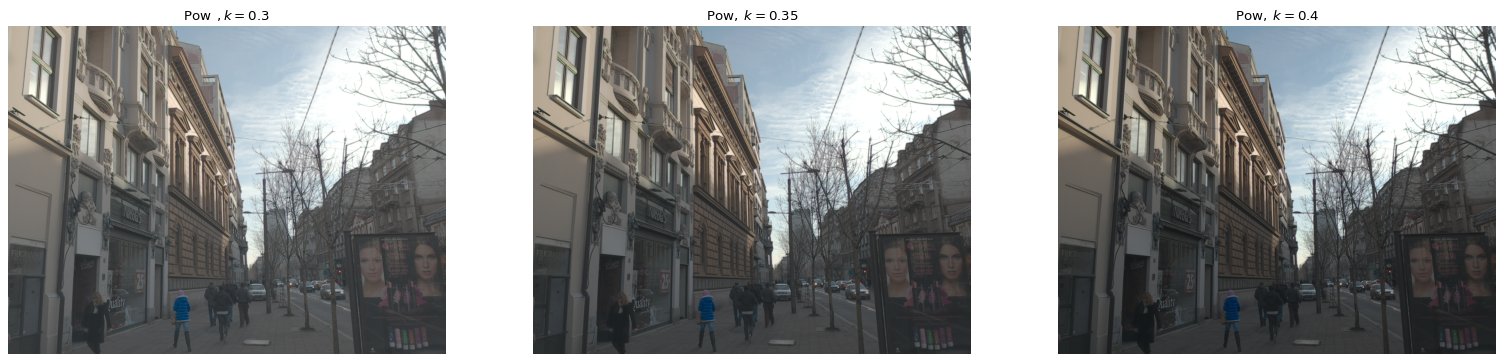

In [4]:
data_dir = "sekvence"
img = skimage.io.imread(data_dir + "/street.tif")

height, width = img[:, :, 0].shape

img = img / img.max()

# Logaritamska transformacija
y11 = log_transform(img, 1.5)
y12 = log_transform(img, 2.3)
y13 = log_transform(img, 2.5)

# Stepena transformacija
y21 = root_transform(img, 0.3)
y22 = root_transform(img, 0.35)
y23 = root_transform(img, 0.4)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,22), dpi=80)
ax = axes.ravel()

ax[0].imshow(y11)
ax[0].set_title("Log," + r"$\,\,  k = 10^{1.5}$")
ax[0].axis("off");

ax[1].imshow(y12)
ax[1].set_title("Log," + r"$\,\,  k = 10^{2.3}$")
ax[1].axis("off");

ax[2].imshow(y13)
ax[2].set_title("Log," + r"$\,\,  k = 10^{2.5}$")
ax[2].axis("off");

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,22), dpi=80)
ax = axes.ravel()

ax[0].imshow(y21)
ax[0].set_title("Pow" + r"$\,\,\, , k = 0.3$")
ax[0].axis("off");

ax[1].imshow(y22)
ax[1].set_title("Pow," + r"$\,\,\, k = 0.35$")
ax[1].axis("off");

ax[2].imshow(y23)
ax[2].set_title("Pow," + r"$\,\,\,  k = 0.4$")
ax[2].axis("off");

plt.imsave("images_out/street.jpg", y12)

# Cuvanje slika transformisanih ekvalizacijom 
# histograma i adaptivnom ekvalizacijom histograma
save_equalisation(img);

# # Cuvanje histograma za izvestaj
# save_hist(img, y12);

# # Pronalazenje vrednosti za c_log i k_root koje daju najbolje rezultate  
# interact(best_result_0, img = fixed(img), c_log = (0, 5, 0.1), k_root = (0.05, 1, 0.05));      

## Zadatak 2

Postoji više načina da se izoštravanje uradi. Svi načini se svode na to da se iz slike izdvoje detalji i oni pojačaju, dok se delovi slike na kojima nema detalja ne diraju, tj. što manje diraju. Detalje je moguće izvući rađenjem __prvog__ ili __drugog__ __izvoda__ na elemente slike. U pitanju su diskretne aproksimacije izvoda, pošto je izvod definisan nad kontinualnim signalima. Kada se detalji izvuku, potrebno ih dodati, sa odgovarajućim faktorom, na originalnu sliku. Faktorom se kontroliše koliko će se detalji naglasiti.

Na slici su prikazani efekti koje prvi i drugi izvod imaju. Kada bi se od originalne funkicje oduzeo prvi izvod te funkcije, povećali bismo nagib te funkcije, ali on više ne bi bio linearan, u pitanju je primer sa slike. Bolji pristup je od početne funkcije oduzeti drugi izvbod te funkcije, jer će se linearnost nagiba malo iskvariti, dosta manje u poređenju sa prvim izvodom, ali še se nagib još više povećati, u odnosu na prvi izvod. Treba biti pažljiv sa odabirom faktora, kojim se od originalnog signala oduzima drugi izvod, jer može doći do prenaglašenih ivica, jednim delom zbog nagiba funkcije, drugim zbog __overshoot-a__ i __undershoot-a__ što je direktna posledica drugog izvoda.
 
<center><img src="images_report/s3.png"/></center>

Da bismo sve ovo primenili na sliku, potrebno je raditi izvode u oba pravca, x i y. 

$$
    \nabla f[x, y] = f[x + 1, y] + f[x, y + 1] - 2 \, f[x, y]
$$
$$
    \nabla^2 f[x, y] = f[x - 1, y] + f[x + 1, y] + f[x, y - 1] + f[x, y + 1] - 4 \, f[x, y]
$$

Prostorne maske koje odgovaraju ovim jednačinama su 

$$
\begin{bmatrix}
0 & 0 & 0\\
0 & -2 & 1\\
0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0
\end{bmatrix}
$$

Možemo definisati drugačije gradijente, tako da na primer pojačamo ivične efektr, tako što uzmemo u obzir i dijagonalne lemeente. Prva matrica odgovara prvom izvodu, druga matrica drugom izvodu.

$$
\begin{bmatrix}
0 & 0 & 0\\
0 & -1 & 1\\
0 & 1 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 1 & 1\\
1 & -8 & 1\\
1 & 1 & 1
\end{bmatrix}
$$


Pored gradijenta, detalje je moguće izvući __unsharp maskom__. Potrebni je ulaznu sliku filtrirati niskofrekventnim filtrom, na taj način smo potisnuli detalje na slici. Sledeći korak je da od originalne slike oduzmemo zamućenu sliku, time izvlačimo detalje koje sada mođemo, sa odgovarajućim faktorom, dodati originalnoj slici.

<center><img src="images_report/s4.png"/></center>

Izoštravanjem na ove načine možemo povećati __šum__, što je nepoželjno. To bismo mogli da izbegnemo tako što bismo sliku filtrirali malim niskofrekventnim filtrom, što bi uklonilo komponente šuma na visokim frekvencijama, npr. korišćenjem Gausove maske, nakon toga primenjujemo odgovarajuću masku. Izvučene detelje sada dodajemo ne na originalnu sliku, već na sliku filtriranu malim filtrom. Rezultati izoštravanja originalne slike, i originalne slike filtrirane Gausovim foltrom su dati na slici.

<br>
<center><img src="images_report/shigatse_without_filter_h.jpg" width = 500px/> <img src="images_report/shigatse_with_filter_h.jpg" width = 500px/></center>

<br>
<br>
Pitanje je koji metod je najbolji. Da li korišćenje unsharp maske ili laplasijana. Obe metode smanjuju slabije piskele i povećavaju jače piksele, ali laplasijan takođe povećava nagib između jačekg islabijeg piksela, zato je bolji izbor __laplasijan__.

Kako je ulazna slika u __RGB__ formatu, dovoljno je pretvoriti je u __YUV__ format i posmatrati samo __Y__ komponentu. Izoštravanje predstavlja naglašavanje ivica, to se radi tako što se jedna strana posvetli, dok se druga potamni. Kako  samo Y komponenta sadrži informacije o osvetljenosti, dovoljno je primenjivati transformacije samo na nju.

In [5]:
def sharpening_img(img_rgb, filtered):
    
    laplacian_mask = np.array([ [0,  1, 0],
                                [1, -4, 1],
                                [0,  1, 0] ])
    
    img_rgb = img_rgb / img_rgb.max()          # Svodjenje piskela ulazne slika na opseg [0, 1]
    
    img_yuv = skimage.color.rgb2yuv(img_rgb)   # Pretvaranje slike iz RGB formata u YUV format
    img_y = img_yuv[:, :, 0]                   # nulta matrica je Y komponenta sistema
    
    if (filtered):
        img_y_filtered = skimage.filters.gaussian(img_y, sigma=1, truncate=3)    # Uklanjanje visokih ucestanosti, tj. suma
    else:
        img_y_filtered = img_y
    
    img_y_lap = ndimage.correlate(img_y_filtered, laplacian_mask)
    img_y_sharp = img_y_filtered - 1.3*img_y_lap                  # Mnozenje konstantom 1.3, radi veceg naglasavanja detalja
    
    img_y_sharp = np.clip(img_y_sharp, 0, 1)
    
    img_yuv_sharp = np.zeros(img_yuv.shape)
    img_yuv_sharp[:, :, 0] = img_y_sharp
    img_yuv_sharp[:, :, 1:] = img_yuv[:, :, 1:]
    
    sharp_img = skimage.color.yuv2rgb(img_yuv_sharp)
    sharp_img = np.clip(sharp_img, 0, 1)
    
    return sharp_img

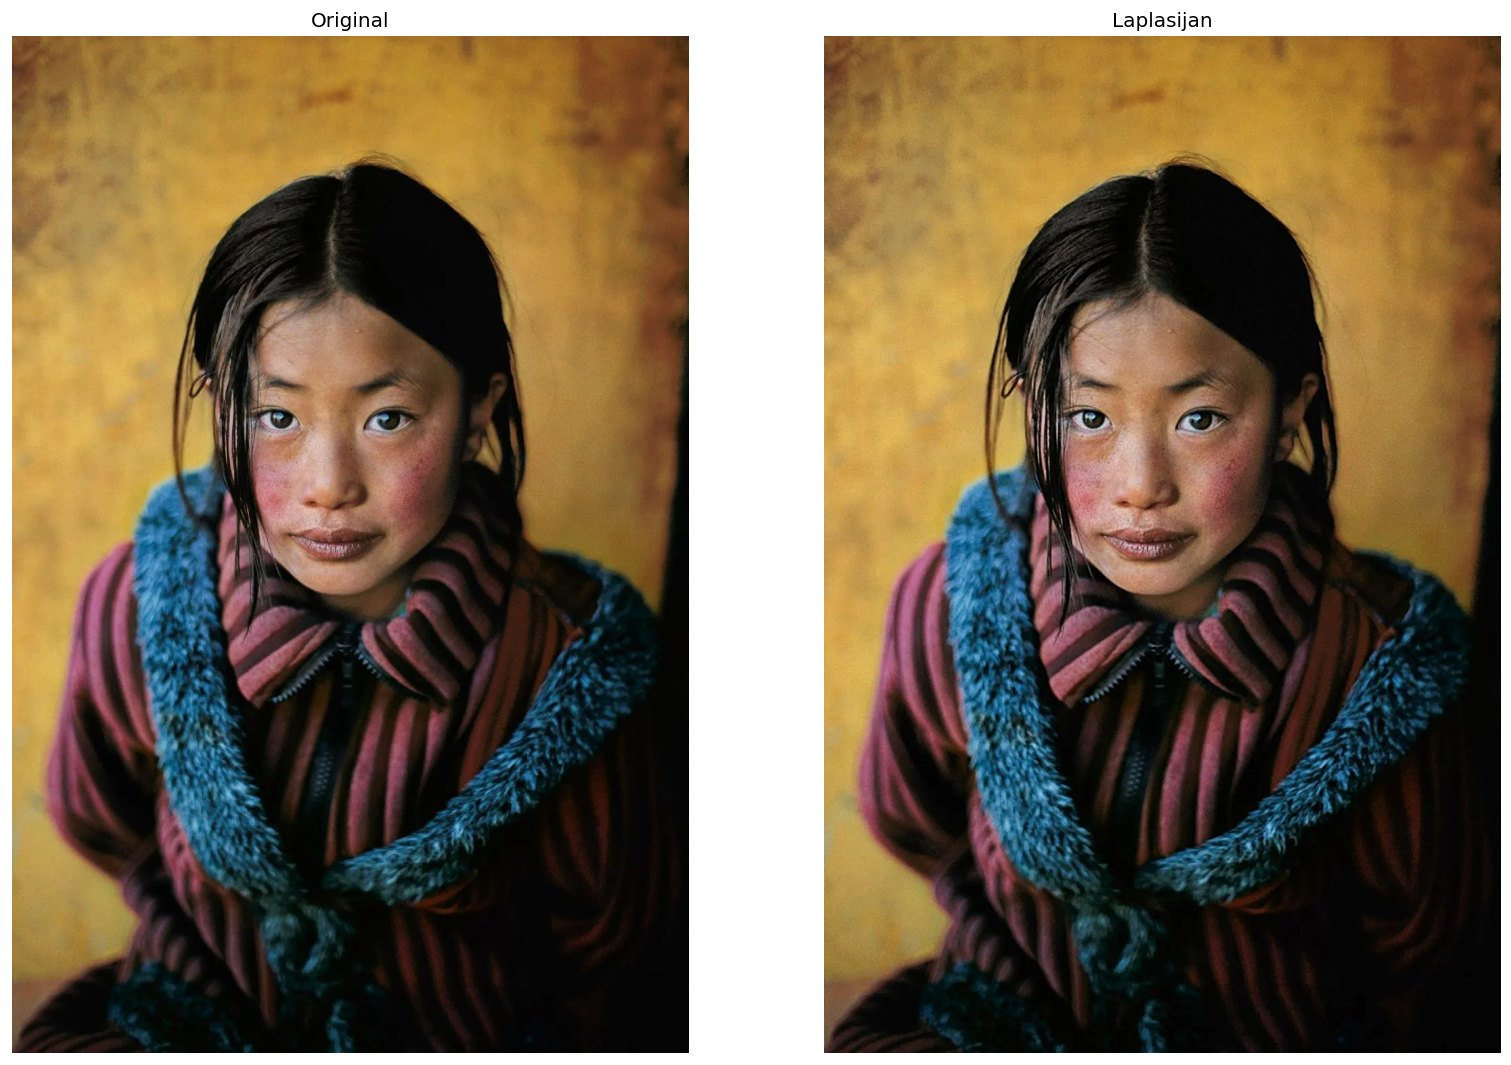

In [6]:
data_dir = "sekvence"
img = plt.imread(data_dir + "/shigatse.jpg")

img = skimage.util.img_as_float(img)      # postavljanje piksela na opseg [0, 1]

# Izostravanje sa prethodnim filtriranjem ulazne slike
img_sharp_lap = sharpening_img(img, True)

# Izostravanje bez prethodnog filtriranja ulazne slike
img_sharp_lap_unf = sharpening_img(img, False)

# Cuvanje rezultata za izvestaj
plt.imsave("images_report/shigatse_without_filter.jpg", img_sharp_lap_unf)
plt.imsave("images_report/shigatse_with_filter.jpg", img_sharp_lap)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,14), dpi=120)
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(img_sharp_lap)
ax[1].set_title("Laplasijan")
ax[1].axis('off');

## Zadatak 3

### Impulsni šum
Izlazne slike su zašumljene impulsnim šumom. Karakteristika takvog šuma je da su vrednosti piksela pogođeni takvim šumom ili vrlo niske ili vrlo visoke. Kako su vrednosti pikesla ograničene, to se manifestuje tako što su pikseli pozitivno ili negativno prezasićeni. Klasični niskofrekventni filtri, koji rade na osnovu srednje vrednosti, ne pomažu. Vernija predstava takvog stanje je __medijana__. Potraban nam je filtar koji pikselu dodeljuje medijanu određenu iz njegovog susedstva.

$$
    y[m, n] = \text{median}{x[m - k, n - l]} \,\,\,\,\,\,\, k,l \in S
$$

Nakon primene __medijan filtra__ vidi se da je izlazna slika, pored zašumljenja, invertovala kontrast, što se može potvrditi i gledanjem u histogram. Da bi se kontrast popravio potrebno je prrimeniti funkciju

$$
    y = 1 - x
$$

Razlike između ulazne i izlazne slike su sad uočljivije ako se posmatraju njihovui histogrami. Vidi se da je potrebno proširiti histogram izlazne slike. Da bi se kvalitet dodatno popravio, može se izvršiti izoštravanje. Na histogramu se vidi da linije postaju gušće, tj. histogram postaje približniji histogramu originalne slike. Razlike između histograma i dalje postoje zbog toga što medijan filtar nije idealan filtar.

<center><img src="sekvence/original1.png" width = 500/></center>
<br>
<center><img src="images_report/img_corrupted_med.png" width = 500/></center>
<br>
<center><img src="images_report/img_corrupted_med_inverted.png" width = 500/></center>
<br>
<center><img src="images_report/img_restored_blurred.png" width = 500/></center>
<br>
<center><img src="images_report/img_restored.png" width = 500/></center>
<br>

<center><img src="images_report/img_original1_hist.png" width = 600/></center>
<br>
<center><img src="images_report/img_corrupted_med_hist.png" width = 600/></center>
<br>
<center><img src="images_report/img_corrupted_med_inverted_hist.png" width = 600/></center>
<br>
<center><img src="images_report/img_restored_blurred_hist.png" width = 600/></center>
<br>
<center><img src="images_report/img_restored_hist.png" width = 600/></center>
<br>

In [7]:
# Crtanje histograma
def print_histogram(img, img_title): 
    
    img = skimage.img_as_ubyte(img)
    hist_img, bin_edges = np.histogram(img.flatten(), bins=256, range=(0,255))

    fig, ax = plt.subplots()
    plt.bar(bin_edges[0:-1], hist_img, color='b')
    plt.title(img_title)
    
# Izostravanje slike
def sharp_image(img):
    
    lowpass_mask = np.ones(shape=(3, 3)) / 9
    
    img_blurred = ndimage.correlate(img, lowpass_mask)  # Uklanjanje detalja sa slike
    img_details = img - img_blurred                     # Izvlacenje detalja iz slike
    img_sharp = img + 2 * img_details                   # Mnozenje sa 2 da bi se naglasili detalji
    
    img_sharp = np.clip(img_sharp, 0, 1)                # Moze se desiti prekoracenje vrednosti piksela prilikom ovih operacija, potrebno ih je ograniciti
    
    return img_sharp

# Restauracija slike
def restore_image(img_corrupted, img_original):
    
    img_corrupted_med = skimage.filters.median(img_corrupted, np.ones(shape=(5, 5)))    # Filtriranje medijan filtrom
    
    img_corrupted_med_inverted = 1 - img_corrupted_med                                  # Inverzija kontrasta
    
    p0, p1 = np.percentile(img_original, (0, 100))                                      # Pod pretpostavkom da svi pikseli ulazne slike nose zeljenu informaciju
    k0, k1 = np.percentile(img_corrupted_med_inverted, (0, 100))                         
    
    img_restored_blurred = skimage.exposure.rescale_intensity(img_corrupted_med_inverted, in_range=(k0, k1), out_range=(p0, p1))  # Prosirenje histograma
    
    img_restored = sharp_image(img_restored_blurred)                                    # Izostravanje slike
    
    return img_restored

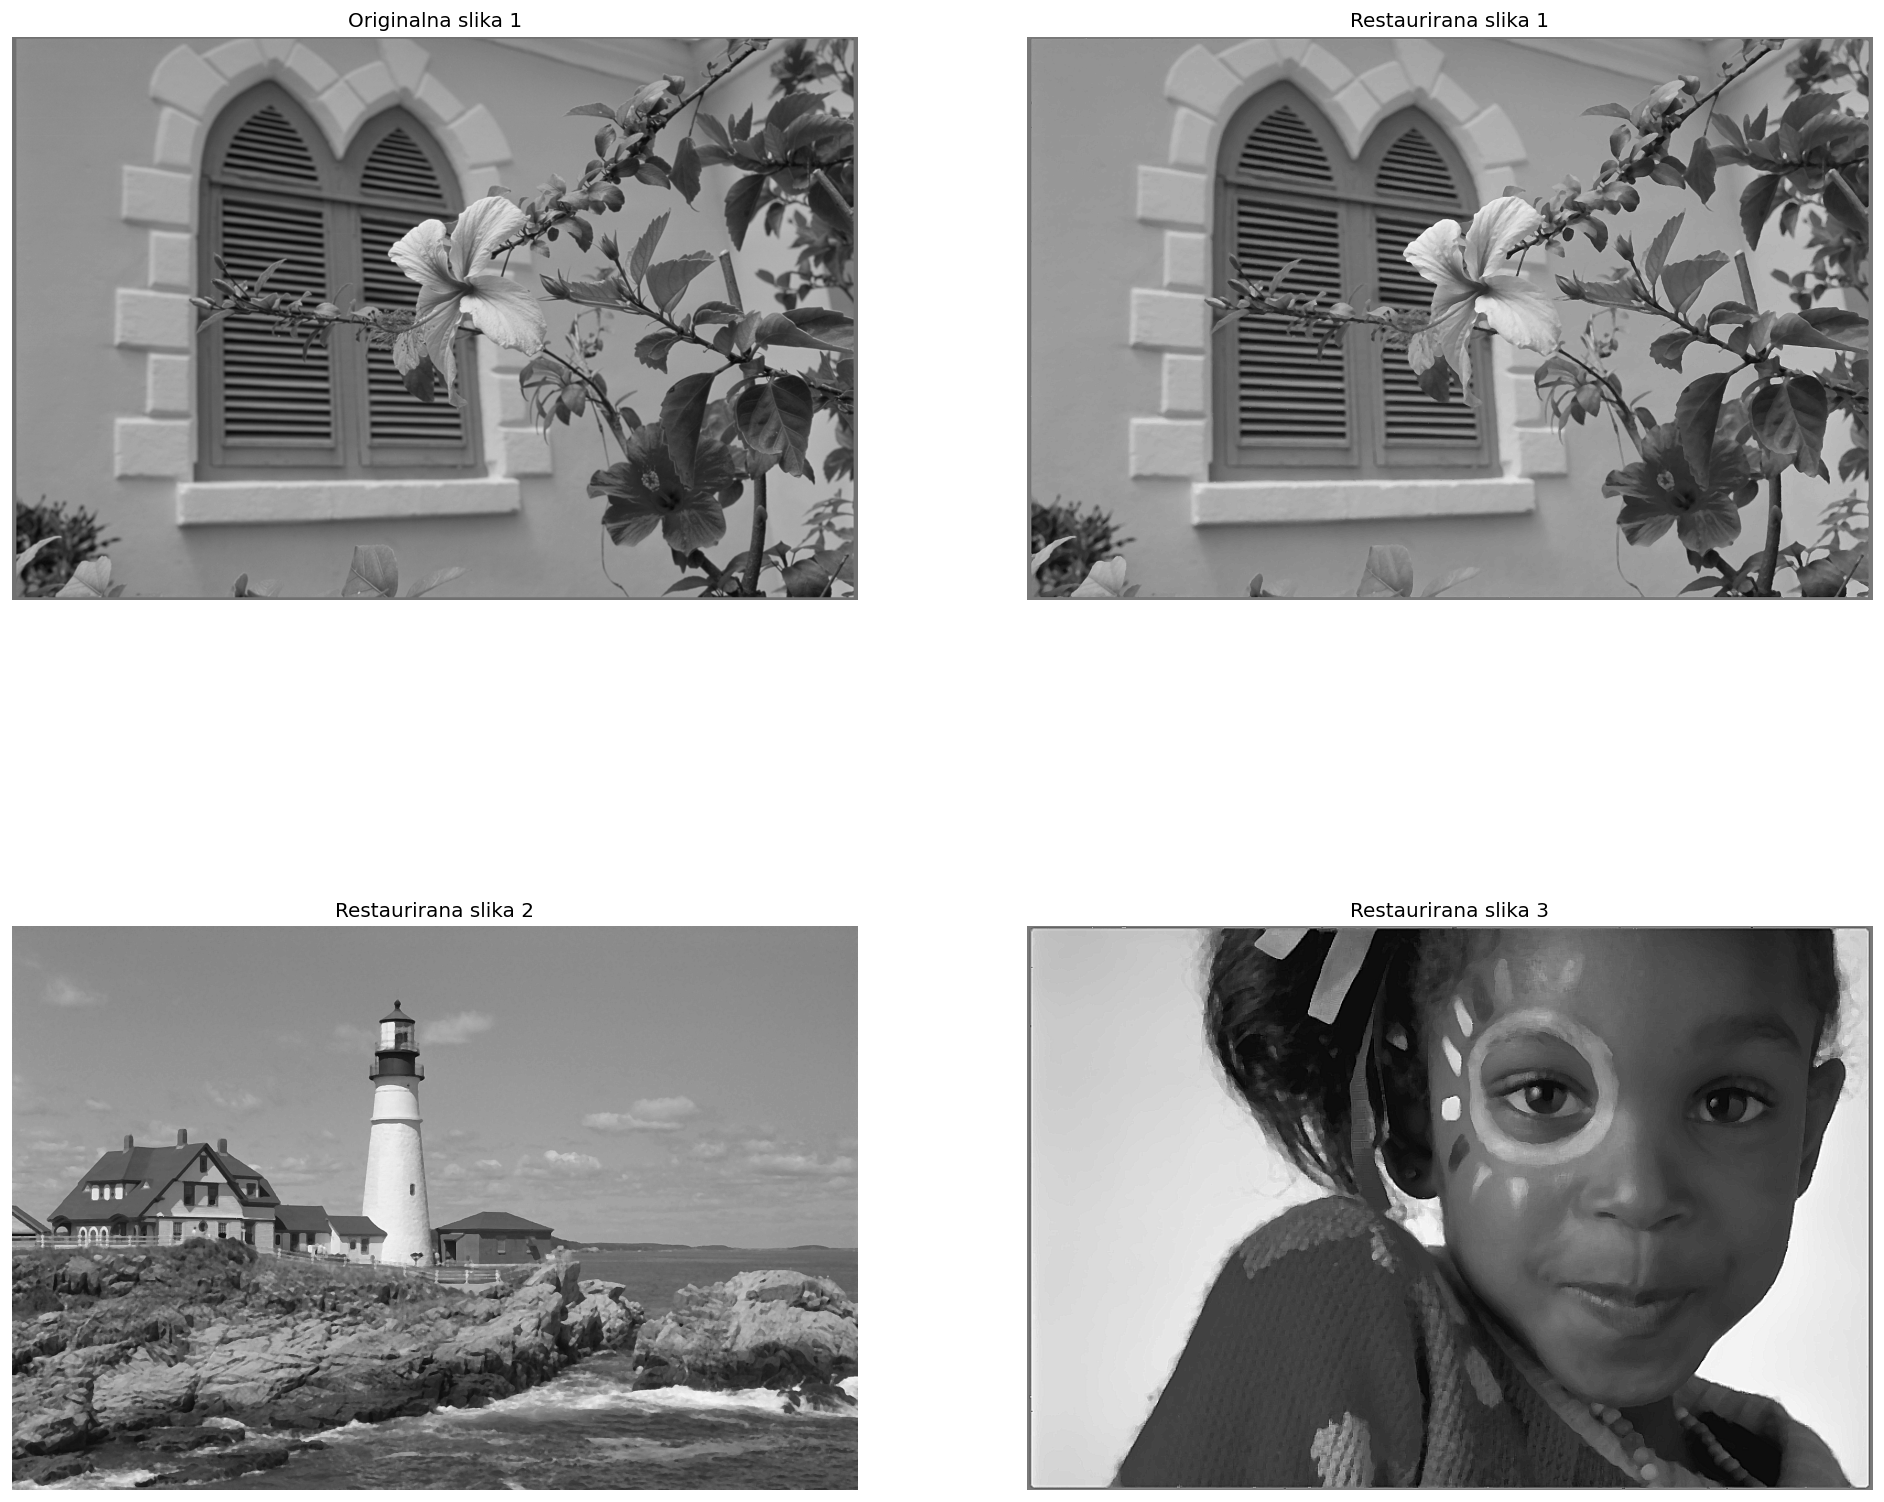

In [8]:
data_dir = "sekvence"

img_original1 = skimage.util.img_as_float(skimage.io.imread(data_dir + "/original1.png"))
img_corrupted1 = skimage.util.img_as_float(skimage.io.imread(data_dir + "/corrupted1.png"))
img_corrupted2 = skimage.io.imread(data_dir + "/corrupted2.png")
img_corrupted3 = skimage.io.imread(data_dir + "/corrupted3.png")

img_restored1 = restore_image(img_corrupted1, img_original1)
img_restored2 = restore_image(img_corrupted2, img_original1)
img_restored3 = restore_image(img_corrupted3, img_original1)

# plt.imsave("images_out/img_restored1_out.png", img_restored1, cmap = "gray");
# plt.imsave("images_out/img_restored2_out.png", img_restored2, cmap = "gray");
# plt.imsave("images_out/img_restored3_out.png", img_restored3, cmap = "gray");

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,18), dpi=120)
ax = axes.ravel()

ax[0].imshow(img_original1, cmap = "gray")
ax[0].set_title("Originalna slika 1")
ax[0].axis('off')

ax[1].imshow(img_restored1, cmap = "gray")
ax[1].set_title("Restaurirana slika 1")
ax[1].axis('off')

ax[2].imshow(img_restored2, cmap = "gray")
ax[2].set_title("Restaurirana slika 2")
ax[2].axis('off')

ax[3].imshow(img_restored3, cmap = "gray")
ax[3].set_title("Restaurirana slika 3")
ax[3].axis('off');


# print_histogram(img_original1, "Original Image")
# print_histogram(img_restored1, "Restored Image 1")
# print_histogram(img_restored2, "Restored Image 2")
# print_histogram(img_restored3, "Restored Image 3")

Funkcija koja generise slike potrebne za izvestaj

In [9]:
# data_dir = "sekvence"
# img_original1 = skimage.util.img_as_float(skimage.io.imread(data_dir + "/original1.png"))
# img_corrupted1 = skimage.util.img_as_float(skimage.io.imread(data_dir + "/corrupted1.png"))

# img_corrupted_med = skimage.filters.median(img_corrupted1, np.ones(shape=(5, 5)))
# plt.imsave("images_report/img_corrupted_med.png", img_corrupted_med, cmap = "gray");
    
# img_corrupted_med_inverted = 1 - img_corrupted_med
# plt.imsave("images_report/img_corrupted_med_inverted.png", img_corrupted_med_inverted, cmap = "gray");

# p0, p1 = np.percentile(img_original1, (0, 100))
# k0, k1 = np.percentile(img_corrupted_med_inverted, (0, 100))

# img_restored_blurred = skimage.exposure.rescale_intensity(img_corrupted_med_inverted, in_range=(k0, k1), out_range=(p0, p1))
# plt.imsave("images_report/img_restored_blurred.png", img_restored_blurred, cmap = "gray");

# img_restored = sharp_image(img_restored_blurred)
# plt.imsave("images_report/img_restored.png", img_restored, cmap = "gray");


# img_corrupted_med = skimage.img_as_ubyte(img_corrupted_med)
# hist_img, bin_edges = np.histogram(img_corrupted_med.flatten(), bins=256, range=(0,255))

# fig, ax = plt.subplots()
# plt.bar(bin_edges[0:-1], hist_img, color='b')
# plt.title("Filtriranje medijan filtrom")
# plt.savefig("images_report/img_corrupted_med_hist.png")

# img_corrupted_med_inverted = skimage.img_as_ubyte(img_corrupted_med_inverted)
# hist_img, bin_edges = np.histogram(img_corrupted_med_inverted.flatten(), bins=256, range=(0,255))

# fig, ax = plt.subplots()
# plt.bar(bin_edges[0:-1], hist_img, color='b')
# plt.title("Invertovan kontrast")
# plt.savefig("images_report/img_corrupted_med_inverted_hist.png")

# img_restored_blurred = skimage.img_as_ubyte(img_restored_blurred)
# hist_img, bin_edges = np.histogram(img_restored_blurred.flatten(), bins=256, range=(0,255))

# fig, ax = plt.subplots()
# plt.bar(bin_edges[0:-1], hist_img, color='b')
# plt.title("Proširenje histograma")
# plt.savefig("images_report/img_restored_blurred_hist.png")

# img_restored = skimage.img_as_ubyte(img_restored)
# hist_img, bin_edges = np.histogram(img_restored.flatten(), bins=256, range=(0,255))

# fig, ax = plt.subplots()
# plt.bar(bin_edges[0:-1], hist_img, color='b')
# plt.title("Izoštrena slika")
# plt.savefig("images_report/img_restored_hist.png")

# img_original1 = skimage.img_as_ubyte(img_original1)
# hist_img, bin_edges = np.histogram(img_original1.flatten(), bins=256, range=(0,255))

# fig, ax = plt.subplots()
# plt.bar(bin_edges[0:-1], hist_img, color='b')
# plt.title("Ulazna slika")
# plt.savefig("images_report/img_original1_hist.png")

## Zadatak 4

### Bilateralno filtriranje
Javlja se problem degradiranja ivica kod klasičnog filtriranja. Klasično filtriranje usrednjava piksele koji su dosta različiti, na ivicama. Kako bi se to rešilo, koristi se __bilateralno filtriranje__. Takvo filtriranje koristi masku koja pored __prostorne__ udaljenosti piksela od centralnog piksela, uzima i udaljenost __vrednosti__ piksela od vrednosti centralnog piksela. Na taj način, bilateralni filtar filtrira mala odstupanja iymedju piksela, dok velika odstupanja ne dira. Ta velika odstupanja predstavljaju ivice, koje filtar svakako ne treba da dira.

$$
    \Large w[s, t] = e^{-\frac{s^2 + t^2}{2 \, \sigma_s^2}} \, e^{-\frac{(f[x + s, y + t] - f[x, y])^2}{2 \, \sigma_r^2}}
$$

Kako elementi maske bilateralnog filtra zavise od piksela, mora se unutar petlje prolaziti kroz svaki piksel slike, i za svaki piksel računati maska. Kako ne bismo dva puta prolazili kroz sve piksele, možemo jednom proći i u isto vreme izračunati tešinsku masku za dati piksel i uraditi korelaciju sa okolinom tok piksela. Okolinu piksela određuje parametar $radius$. Da bi korelacija mogla nesmetano da se obavlja i po ivicama slike, potrebno je ulaznu sliku proširiti. Ulazna matrica je dimenzije $3 x 3$, proširena matrica je dimenzije $5x5$ zazo što je $radius = 1$. Dodatni elementi u proširenu matricu se stavljaju tako da se ogledaju kao u ogledalu sa elementima ulazne matrice. Elementi na ćoškovima proširene matrice, uzimaju vrednosti sa ćoškova ulazne matrice. 

$$
\begin{bmatrix}
1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9
\end{bmatrix}
$$

$$
\begin{bmatrix}
1 & 1 & 2 & 3 & 3\\
1 & 1 & 2 & 3 & 3\\
4 & 4 & 5 & 6 & 6\\
7 & 7 & 8 & 9 & 9\\
7 & 7 & 8 & 9 & 9\\
\end{bmatrix}
$$

Prvi deo maske $e^{-\frac{s^2 + t^2}{2 \, \sigma_s^2}}$ možemo izračunati pre nego što krenemo sa iteracijom kroz svaki piksel, na taj način ta vrednost se ne računa omoliki broj puta koliko ima piksela, već samo jednom. Drugi deo maske, koji zavisi od udaljenosti vrednosti piksela od vrednosti centralnog piksela, moramo računati unutar petlje, jer zavisi od piksela. 

Data formula za određivanje elemenata matrice nije normalizovana. Normalizacija je bitna jer filtar ne treba da menja piksele čije je okruženje jednako samom pikselu. Normalizacija se vrši tako što se elementi težinske maske podele sa sumom elemenata te maske.

Na kraju je potreabno uraditi korelaciju težinske maske sa lokalnim okruženjem piksela na kome se nalazimo unutar petlje. To znači da je potrebno $MxN$ iteracija, gde je $M$ broj vrsta matrice a $N$ broj kolona.
<br>

$$
    \large g[x, y] = \frac{\sum_{s = -a}^a  \sum_{t = -b}^b w[s, t] \, f[x + s, y + t]}{\sum_{s = -a}^a \sum_{t = -b}^b w[s, t]}
$$

<br>
<br>
Ugrađena funkcija je brža od moje. Ona koristi aproksimativne metode kako bi izračunala na brži način elemente težinske matrice. Moja funkkcija koristi egzaktne metode. Razlike se vide i u brzini ali i u samoj slici. Što je veličina prozora veća to su razlike između moje i ugrađene funkcije veće. Za velike vrednosti veličine prozora više piksela, sa malim udaljenostima u intenzitetu, ulazi u usrednjavanje, pa će aproksimativne metode dati lošije rezultate. To je upravo jedan od razloga zašto ugrađena funkcija deformiše sliku za velike vrednosti prozora. Razlika, zbog aproksimacija, se može lepo uočiti za parametre $\sigma_s = 10, \sigma_r = 0.5, radius = 30$, vidi se da ugrađena funkcija skroy deformiše sliku. Slika bi trebalo da je mutna, ali da su ivice i dalje oštre, upravo takve rezultate daje moja funkcija.

<br>
<br>

#### Vremena izvršavanja za obradu jedne ravni slike 

| radius                         | 2      | 4     | 10     | 20    | 30     | 40      |
| ---                            | ---    | ---   | ---    | ---   | ---    | ---     |
| moja $[s]$                     | 3.272  | 3.525 |  4.58  | 7.623 | 12.021 |  17.453 |
| moja  $[\frac{\mu s}{pix}]$    | 10.882 | 9.607 | 12.91  | 21.19 | 36.127 | 52.596  |
| ugrađena $[s]$                 | 4.295  | 0.16  |  0.912 | 3.31  | 7.664  |  12.686 |
| ugrađena $[\frac{\mu s}{pix}]$ | 0.172  | 0.488 | 2.586  | 9.049 | 20.591 | 37.116  |


#### Vremena izvršavanja za obradu sve tri ravni slike 

| radius                         | 2      | 4      | 10      | 20     | 30      | 40      |
| ---                            | ---    | ---    | ---     | ---    | ---     | ---     |
| moja $[s]$                     | 9.892  | 10.848 |  15.878 | 23.119 | 36.116  |  56.805 |
| moja $[\frac{\mu s}{pix}]$     | 27.176 | 28.292 | 40.367  | 63.56  | 108.238 | 155.563 |
| ugrađena $[s]$                 | 0.126  | 0.323  |  1.548  | 6.04   | 12.477  |  26.128 |
| ugrađena $[\frac{\mu s}{pix}]$ | 0.239  | 0.85   | 4.325   | 16.462 | 38.259  | 63.604  |

<br>
 

<center><img src="images_report/my_sigmas5.png" width = 735/>                    <img src="images_report/their_sigmas5.png" width = 735/></center>
<center><img src="images_report/my_sigmas10.png" width = 735/>                      <img src="images_report/their_sigmas10.png" width = 735/></center>

In [10]:
# Funkcija koja prosiruje zadatu ravan slike
# Moze biti slika u boji ili siva slika
def resize_array(x, radius):
    
    M, N = x.shape[:2]    # M je broj vrsta, N je broj kolona 
    
    # Inicijalizacija prosirene matrice, tako da filtriranje bude moguce i na ivicama slike
    resized_x = np.zeros((M + 2*radius, N + 2*radius), dtype = float) 
    
    # Popunjavanje coskova prosirene matrice elementima sa coskova originalne matrice x[0,0], x[M-1,0], x[0,N-1], x[M-1,N-1]
    resized_x[0:radius, 0:radius] = x[0, 0]
    resized_x[radius+M : 2*radius+1+M, 0:radius] = x[M-1, 0]
    resized_x[0:radius, radius+N : 2*radius+1+N] = x[0, N-1]
    resized_x[radius+M : 2*radius+1+M, radius+N : 2*radius+1+N] = x[M-1, N-1]
    
    # Popunjavanje sredine prosirene matrice elementima originalne matrice
    resized_x[radius : radius+M, radius : radius+N] = x

    # Popunjavanje ivica prosirene matrice elementima sa ivica originalne matrice tako da se slikaju kao u ogledalu
    # Simetry
    resized_x[0:radius, radius:radius+N] = x[radius-1::-1][:]
    resized_x[radius:radius+M, 0:radius] = x[:,radius-1::-1]
    resized_x[radius+M:, radius:radius+N] = x[:M-radius-1:-1, :]
    resized_x[radius:radius+M, radius+N: ] = x[:, :N-radius-1:-1]
    
    return resized_x

def colerate(x, resized_x, radius, filter_mask_gauss, sigma_r, i, j):
    tmp_resized_x = resized_x[i : i+2*radius+1, j : j+2*radius+1]                                                        # Pomocna promeljiva koja sadrzi matricu lokalnog susedstva selektovanog piksela
    mask = filter_mask_gauss * np.exp(-(tmp_resized_x - x[i, j]) * (tmp_resized_x - x[i, j]) / (2 * sigma_r * sigma_r))  # Finalna maska
    mask = mask / mask.sum()                                                                                             # Normalizacija tezinske maske
    return (mask * tmp_resized_x).sum()
    
# Funkcija koja vrsi bilateralno filtriranje ulazne slike
def bilateral_filter(x, radius, sigma_s, sigma_r):
    
    """Ulazni argumenti: 
    
                        x :    Ulazna slika koju filtriramo.
                               Opseg ulazne slike je [0, 1].
                               Ulazna slika moze biti u RGB formatu ili siva slika. 
                               Ukoliko je u RGB formatu funkcija vrsi 3 puta iste operacije 
                               onoliko puta koliko ima piksela u slici, efektivno je isto kao 
                               da se funkciji, koja prima samo jednu ravan, prosledjuju 3 ravni zasebno.
                                
                   radius :    Pozitivan ceo broj. Odredjuje velicinu tezinske maske.
                               Dimenzije tezinske maske su (2*r+1)x(2*r+1).
                               
                  sigma_s :    Pozitivan realan broj. Predstavlja kojim delom susedni piskeli, pribliznih rastojanja u intenzitetu, 
                               ucestvuju u formiranju elemenata tezinske maske. Sto je parametar veci to susedni pikseli vise ucestvuju
                               u formiranju elemenata tezinske maske.
                               
                  sigma_r :    Pozitivan realan broj u opsegu (0, 1]. Kako je opseg vrednosti piksela ulazne slike [0, 1], a sigma_r predstavlja 
                               standardnu devijaciju pa nema smisla da ona bude veca od maksimalne vrednosti ulaznih podataka. Sto je sigma_r
                               vece to pikseli cije su vrednosti na vecem rastojanju od vrednosti centralnog piksela imaju veci uticaj u tezinskoj masci.
    
       Izlazni argumenti:
       
                filtered_x:    Izlazna filtrirana slika u opsegu [0, 1].
                            """
    
    # Provera validnosti unetih parametara, ako x nije iz opsega [0, 1] ili radius nije ceo broj veci od 0
    if(x.min() < 0 or x.max() > 1):
        raise ValueError("Elements of image must be in range [0, 1]")
    if(radius <= 0 or int(radius) != radius):
        raise ValueError("Radius must be positive integer")
    if(sigma_s <= 0):
        raise ValueError("sigma_s must be positive")
    if(sigma_r <= 0 or sigma_r > 1):
        raise ValueError("sigma_r must be in range (0, 1]");
    
    M, N = x.shape[:2]    # M je broj vrsta, N je broj kolona 
    
    # Provera da li je ulazna slika siva, ili u boji. Ako je x.shape duzine 2, to je 2D array, tj. siva slika u suprotnom je 3D array, tj. slika u boji 
    if(len(x.shape) > 2):
        resized_x_r = resize_array(x[:, :, 0], radius)
        resized_x_g = resize_array(x[:, :, 1], radius)
        resized_x_b = resize_array(x[:, :, 2], radius)
    else:
        resized_x = resize_array(x, radius)

    # Pravljenje matrice koja ce sadrzati informaciju o udaljenosti piksela iz okruzenja od centralnog piksela
    k = list(range(-radius, radius+1))
    l = list(range(-radius, radius+1))
    K, L = np.meshgrid(k, l)
    
    # Gausova maska 
    filter_mask_gauss = np.exp(-(K * K + L * L) / (sigma_s * sigma_s * 2))
    
    # Inicijalizacija matrice koja ce sadrzati filtriranu sliku u boji ili sivu
    if(len(x.shape) > 2):
        filtered_x_r = np.zeros((M, N), dtype = np.double)
        filtered_x_g = np.zeros((M, N), dtype = np.double)
        filtered_x_b = np.zeros((M, N), dtype = np.double)
        filtered_x = np.zeros(x.shape, dtype = np.double)
    else:
        filtered_x = np.zeros((M, N), dtype = np.double)
    
    # Petlja koja prolazi kroz svaki piksel, i boji vrste, j broji kolone
    for i in range(M):
        for j in range(N):
            
            # Provera da li je ulazna slika siva, ili u boji. Ako je x.shape duzine 2, to je 2D array, tj. siva slika 
            if(len(x.shape) > 2):
                filtered_x[i, j, 0] = colerate(x[:, :, 0], resized_x_r, radius, filter_mask_gauss, sigma_r, i, j)
                filtered_x[i, j, 1] = colerate(x[:, :, 1], resized_x_g, radius, filter_mask_gauss, sigma_r, i, j)
                filtered_x[i, j, 2] = colerate(x[:, :, 2], resized_x_b, radius, filter_mask_gauss, sigma_r, i, j)
            else:
                filtered_x[i, j] = colerate(x, resized_x, radius, filter_mask_gauss, sigma_r, i, j)
         
    return filtered_x

In [ ]:
# Funkcija za racunanje i cuvanje vremena izvrsavanja moje i ugradjene funkcije
# Cuvaju se u txt fajlu
import time
data_dir = "sekvence"
x = skimage.io.imread(data_dir + "/lena.png")
x = x / x.max()

N = 1e6 / np.size(x)

radiuses = [2, 4, 10, 20, 30, 40]

with open("vremena_izvrsavanja.txt", 'w') as f:
    f.write("Vremena za obradu sive slike\n")
    for radius in radiuses:
        start = time.time()
        y = bilateral_filter(x[:, :, 0], radius, 1, 0.5)
        end = time.time()
        f.write("Vreme izvrsavanja moje funkcije za r = " + str(radius) + "[s]: " + str(round(end - start, 3)) + '\n')
        f.write("Vreme izvrsavanja moje funkcije za r = " + str(radius) + "[us/pix]: " + str(round((end - start)*N, 3)) + '\n')
        
        start = time.time()
        y = skimage.restoration.denoise_bilateral(x[:, :, 0], win_size=2*radius+1, sigma_color=0.5, sigma_spatial=1, mode = "symmetric")
        end = time.time()
        f.write("Vreme izvrsavanja ugradjene funkcije za r = " + str(radius) + "[s]: " + str(round(end - start, 3)) + '\n')
        f.write("Vreme izvrsavanja ugradjene funkcije za r = " + str(radius) + "[us/pix]: " + str(round((end - start)*N, 3)) + '\n\n')
    f.write('\n')
f.close()

with open("vremena_izvrsavanja.txt", 'a') as f:
    f.write("Vremena za obradu slike u boji\n")
    for radius in radiuses:
        start = time.time()
        y = bilateral_filter(x, radius, 1, 0.5)
        end = time.time()
        f.write("Vreme izvrsavanja moje funkcije za r = " + str(radius) + "[s]: " + str(round(end - start, 3)) + 's\n')
        f.write("Vreme izvrsavanja moje funkcije za r = " + str(radius) + "[us/pix]: " + str(round((end - start)*N, 3)) + '\n')
        
        start = time.time()
        y = skimage.restoration.denoise_bilateral(x, win_size=2*radius+1, sigma_color=0.5, sigma_spatial=1, mode = "symmetric", channel_axis = -1)
        end = time.time()
        f.write("Vreme izvrsavanja ugradjene funkcije za r = " + str(radius) + "[s]: " + str(round(end - start, 3)) + '\n')
        f.write("Vreme izvrsavanja ugradjene funkcije za r = " + str(radius) + "[us/pix]: " + str(round((end - start)*N, 3)) + '\n\n')
f.close()

In [ ]:
# Funkcija za filtriranje slike sa razlicitim parametrima
data_dir = "sekvence"
x = skimage.io.imread(data_dir + "/lena.png")
x = x / x.max()

y_my = []
y = []
radius = [3, 3, 3, 7, 7, 7, 20, 20, 20, 30, 30, 30]
sigmar = [0.1, 0.5, 0.9, 0.1, 0.5, 0.9, 0.1, 0.5, 0.9, 0.1, 0.5, 0.9]
sigmas = [5, 10]

for j in range(2):
    for i in range(12):
        y_my.append(bilateral_filter(x, radius[i], sigmas[j], sigmar[i]))
        y.append(skimage.restoration.denoise_bilateral(x, win_size=2*radius[i]+1, sigma_color=sigmar[i], sigma_spatial=sigmas[j], mode = "symmetric", channel_axis = -1))

In [ ]:
# Funkcija za prikazivanje slika i njihovo cuvanje
def print_fig(y, radius, sigmar, sigmas, my):
    
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,23), dpi=400)
    ax = axes.ravel()

    for i in range(12):
        ax[i].imshow(y[i])
        ax[i].set_title(r"$\sigma_s = $" + str(sigmas) + r"$\,\,\, \sigma_r = $" + str(sigmar[i]) + r"$\,\,\,$" + str(2*radius[i] + 1) + r"$x$" + str(2*radius[i] + 1))
        ax[i].axis("off");
    
    if(my):
        plt.savefig("images_report/my_sigmas" + str(sigmas) + ".png")
    else:
        plt.savefig("images_report/their_sigmas" + str(sigmas) + ".png");

radius = [3, 3, 3, 7, 7, 7, 20, 20, 20, 30, 30, 30]
sigmar = [0.1, 0.5, 0.9, 0.1, 0.5, 0.9, 0.1, 0.5, 0.9, 0.1, 0.5, 0.9]

print_fig(y[:12], radius,sigmar, 5, False)
print_fig(y[12:], radius,sigmar, 10, False)
print_fig(y_my[:12], radius,sigmar, 5, True)
print_fig(y_my[12:], radius,sigmar, 10, True)